In [598]:
import pandas as pd
import datetime as dt
import swifter
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import copy
import pandas as pd
import swifter
import copy

from collections import namedtuple
from datetime import timedelta, datetime
from matplotlib.patches import Rectangle

In [613]:
def get_files_with_suffix(directory, suffix):
    matching_file = ""
    # Iterate over files in the directory
    for file_name in os.listdir(directory):
        # Check if the file name ends with the specified suffix
        if file_name.endswith(suffix):
            # If it does, add it to the list of matching files
            matching_file = os.path.join(directory, file_name)

    return matching_file

def get_ul_dl_files(directory, ul_port, dl_port):
    ul_sent_file = None
    dl_sent_file = None
    ul_rcv_file = None
    dl_rcv_file = None
    ul_lost_file = None
    dl_lost_file = None
    
    # Iterate over files in the directory
    for filename in os.listdir(directory):
        # Check if the file starts with "processed_sent"
        if filename.startswith("processed_sent"):
            # Split the file name by "_"
            parts = filename.split("_")
            # Check if the last part of the file name is the UL port
            if parts[-1].split(".")[0] == ul_port:
                ul_sent_file = os.path.join(directory, filename)
            # Check if the last part of the file name is the DL port
            elif parts[-1].split(".")[0] == dl_port:
                dl_sent_file = os.path.join(directory, filename)
        
        # Check if the file starts with "processed_sent"
        if filename.startswith("processed_rcv"):
            # Split the file name by "_"
            parts = filename.split("_")
            # Check if the last part of the file name is the UL port
            if parts[-1].split(".")[0] == ul_port:
                ul_rcv_file = os.path.join(directory, filename)
            # Check if the last part of the file name is the DL port
            elif parts[-1].split(".")[0] == dl_port:
                dl_rcv_file = os.path.join(directory, filename)
        
        if filename == "ul_real_lost_pk.csv":
            ul_lost_file = filename

        if filename == "dl_real_lost_pk.csv":
            dl_lost_file = filename

    return {"ul_sent_file": ul_sent_file, "dl_sent_file": dl_sent_file, "ul_rcv_file": ul_rcv_file, "dl_rcv_file": dl_rcv_file, "ul_lost_file": ul_lost_file, "dl_lost_file": dl_lost_file}

In [616]:
date = "2024-01-26"
exp_name = "QUIC-450sec"
device = "sm00"
round = "#02"
ul_time_diff = timedelta(seconds=0)
dl_time_diff = timedelta(seconds=0)

# database = "/Volumes/mollyT7/MOXA"
database = "/Users/molly/Desktop"

##### GET PORT #####
device_to_ports = {
    "sm00": {"ul_port": "5200", "dl_port": "5201"},
    "sm01": {"ul_port": "5202", "dl_port": "5203"},
    "sm02": {"ul_port": "5204", "dl_port": "5205"}
}
ul_port = device_to_ports[device]["ul_port"]
dl_port = device_to_ports[device]["dl_port"]

##### GET RRC FILE #####
directory_path = f"{database}/{date}/{exp_name}/{device}/{round}/data/"
rrc_suffix = "_rrc.csv"
rrc_file = get_files_with_suffix(directory_path, rrc_suffix)
parts = rrc_file.split("_")
if len(parts) >= 5:
    start_time = "_".join(parts[3:5])
    print("Start time:", start_time)
else:
    print("File name does not contain enough parts.")

##### GET DATA FILES #####
files_dict = get_ul_dl_files(directory_path, ul_port, dl_port)
print(files_dict)
ul_sent_file = files_dict["ul_sent_file"]
dl_sent_file = files_dict["dl_sent_file"]
ul_rcv_file = files_dict["ul_rcv_file"]
dl_rcv_file = files_dict["dl_rcv_file"]
ul_lost_file = files_dict["ul_lost_file"]
dl_lost_file = files_dict["dl_lost_file"]

###### EXTRACT TIME #####
filename = os.path.basename(ul_sent_file)
time = filename.split("_")[2]
print("Time:", time)

##### FIGURE PATH #####
# figure_path = f"/Users/molly/Desktop"
figure_path = f"{database}/{date}/{exp_name}/{device}/{round}/statistics"

Start time: 2024-01-26_16-09-06
{'ul_sent_file': '/Users/molly/Desktop/2024-01-26/QUIC-450sec/sm00/#02/data/processed_sent_1609_4200.csv', 'dl_sent_file': '/Users/molly/Desktop/2024-01-26/QUIC-450sec/sm00/#02/data/processed_sent_1609_4201.csv', 'ul_rcv_file': '/Users/molly/Desktop/2024-01-26/QUIC-450sec/sm00/#02/data/processed_rcv_1609_4200.csv', 'dl_rcv_file': '/Users/molly/Desktop/2024-01-26/QUIC-450sec/sm00/#02/data/processed_rcv_1609_4201.csv', 'ul_lost_file': None, 'dl_lost_file': None}
Time: 1609


In [555]:
event_dict = {'Conn_Rel': 1, 'Conn_Req': 2, 'LTE_HO': 3, 'MN_HO': 4, 'MN_HO_to_eNB': 5, 'SN_setup': 6, 'SN_Rel': 7, 'SN_HO': 8, 'stable': 0, 
              'RLF_II': 9, 'RLF_III': 10, 'SCG_RLF': 11, 'Add_Scell': 12}
colors_dict = {'Conn_Rel': '#ed5555', 'Conn_Req': '#78c4b1', 'LTE_HO': '#3ea357', 'MN_HO': '#e8803a', 
               'MN_HO_to_eNB': '#ad58c4', 'SN_setup': '#ddbfde', 'SN_Rel': '#a1543f', 'SN_HO': '#d4c68a', 'stable': '#878483',
               'RLF_II': '#59a2c2', 'RLF_III': '#6494c4', 'SCG_RLF': '#646fc4'}

## Handover

### HO Classify

In [556]:
def parse_mi_ho(f):

    df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8)) 
    nr_pci = 'O'
    scells = []

    def NR_OTA(idx):

        if df["type_id"].iloc[idx] == "5G_NR_RRC_OTA_Packet": return True
        else: return False
    
    def LTE_SERV_INFO(idx):

        if df["type_id"].iloc[idx] == "LTE_RRC_Serv_Cell_Info": return True
        else: return False
    
    def find_1st_after(start_idx, target, look_after=1):
        for j in range(start_idx, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(start_idx, target, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before_with_special_value(start_idx, target, target_value, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [target_value] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_in_D_exact(targets):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.start).total_seconds(), target))

        if len(l) != 0:
            for x in l:
                if (x[0]== 0):
                    return x[1]
        
        return None
    
    def find_in_D_first_before(targets, look_before=1):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.end).total_seconds(), target, ho))

        if len(l) != 0:
            closest = min(filter(lambda x: x[0] > 0, l), key=lambda x: x[0])
            if 0 <= closest[0] < look_before:
                return closest[1], closest[2]
        
        return None, None

    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])
    
    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR  
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        'Add_SCell': [],
        }
    
    for i in range(len(df)):

        # Pass NR RRC packet. In NSA mode, LTE RRC packet include NR packet message.
        if NR_OTA(i) or LTE_SERV_INFO(i):
            continue

        try: lte_pci, lte_earfcn
        except: 
            lte_pci = df["PCI"].iloc[i]
            lte_earfcn = int(df["Freq"].iloc[i])

        others = ''
        t = df["Timestamp"].iloc[i]

        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            nr_pci = 'O'

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            # Define end of rrcConnectionRequest to be rrcConnectionReconfigurationComplete or securityModeComplete.
            a = find_1st_after(i, 'rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after(i, 'securityModeComplete',look_after=2)[0]
        
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            _, idx = find_1st_after(i, 'ueCapabilityInformation',look_after=1)
            if idx is not None:
                sup_band = df['bandEUTRA'].iloc[idx]
                others += f' supported band: {sup_band}.' 

            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            trans = f'({lte_pci}, {lte_earfcn}) -> ({serv_cell}, {serv_freq})'
            
            # Check if caused by RLF III.
            a, idx = find_1st_before(i, 'rrcConnectionReestablishmentReject', look_before=1)
            if a is not None:
                others += ' After RLF III.'

            D['Conn_Req'].append(HO(start=t,end=end,trans=trans, others=others))

            nr_pci = 'O'
            lte_pci = serv_cell
            lte_earfcn = serv_freq
            
        if df["lte-rrc.t304"].iloc[i] == 1:
            
            end, _ = find_1st_after(i, 'rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = int(df["Freq"].iloc[i]), int(df['dl-CarrierFreq'].iloc[i])

            lte_pci = target_cell
            lte_earfcn = target_freq

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others += f' Set up {n} SCell.'
            else:
                scells = []
            
            if serv_freq != target_freq:
                a,b = find_1st_before(i, "rrcConnectionReestablishmentRequest", 1)
                others += " Inter frequency HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 2)
                    
                    if a is not None:

                        ho_type, ho = find_in_D_first_before(['RLF_II', 'RLF_III'], 2)
                        others += f' Near after RLF of trans: {ho.trans}.'

                    else:
                        
                        ho_type, _ = find_in_D_first_before(['MN_HO_to_eNB', 'SN_Rel'], 2)
                        if ho_type is not None:
                            others += f' Near after {ho_type}.'

                    ori_serv = nr_pci
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) | {ori_serv} -> {nr_pci}'
                    D['SN_setup'].append(HO(start=t, end=end, others=others, trans=trans))

                else:
                    
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                    D['MN_HO'].append(HO(start=t, end=end, others=others, trans=trans))

            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, b = find_1st_before(i, "scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    
                    orig_serv = nr_pci
                    nr_pci = 'O'
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others, trans=trans))
                    
                else:

                    a, _ = find_1st_before(i,"rrcConnectionSetup",3)
                    if a is not None:
                        others += ' Near After connection setup.'
                    if nr_pci == 'O':
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                        D['LTE_HO'].append(HO(start=t, end=end, others=others, trans=trans))
                    else:
                        orig_serv = nr_pci
                        nr_pci = 'O'
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {orig_serv} -> {nr_pci}'
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others, trans=trans))


        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
        
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            orig_serv = nr_pci
            nr_pci = int(df['nr_physCellId'].iloc[i])
            trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
            D['SN_HO'].append(HO(start=t,end=end,trans=trans))


        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:

            end1, _ = find_1st_after(i, 'rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after(i, 'rrcConnectionReestablishmentReject', look_after=1)
            end2, _ = find_1st_after(i, 'securityModeComplete',look_after=3)

            others += ' ' + df["reestablishmentCause"].iloc[i] + '.'
            scells = []

            c, _ = find_1st_before(i, 'scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
                
            serv_cell, rlf_cell = df["PCI"].iloc[i], int(df['physCellId.3'].iloc[i])
            serv_freq = int(df['Freq'].iloc[i])
            
            # Type II & Type III
            if end1 is not None: 

                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                rlf_freq = int(df['Freq'].iloc[idx])
                trans = f'({rlf_cell}, {rlf_freq}) -> ({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_II'].append(HO(start=t,end=end1,others=others,trans=trans))

                lte_pci = serv_cell
                lte_earfcn = serv_freq

            elif b is not None and end2 is not None:
                
                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                rlf_freq = int(df['Freq'].iloc[idx])

                _, idx = find_1st_after(i, "rrcConnectionRequest", 2)
                recon_cell, recon_freq = df['PCI'].iloc[idx], int(float(df['Freq'].iloc[idx]))
                
                trans = f'({rlf_cell}, {rlf_freq}) -> ({recon_cell}, {recon_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_III'].append(HO(start=t,end=end2,others=others,trans=trans)) 

                # lte_pci, lte_earfcn will be updated in rrcConnectionRequest.     
                
            else:

                others+=' No end.'
                D['RLF_II'].append(HO(start=t,others=others))
                print('No end for RLF')

        if df["scgFailureInformationNR-r15"].iloc[i] == 1:

            others += ' ' + df["failureType-r15"].iloc[i] + '.'
            a, idx1 = find_1st_after(i, "rrcConnectionReestablishmentRequest", look_after=1)
            b, idx2 = find_1st_after(i, "lte-rrc.t304", look_after=10)

            if a is not None:

                end1, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentComplete', look_after=1)
                b, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentReject', look_after=1)
                end2 = find_1st_after(idx1, 'securityModeComplete',look_after=3)[0]

                others += ' Result in rrcReestablishment.'
                    
                # Type II & Type III Result
                if end1 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end1,others=others))
                elif b is not None and end2 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end2,others=others))
                else:
                    others += ' No end.'
                    D['SCG_RLF'].append(HO(start=t,others=others))
                    print('No end for scg failure result in rrcReestablishment.')

            elif b is not None:

                end, _ = find_1st_after(idx2, 'rrcConnectionReconfigurationComplete')
                serv_cell, target_cell = df["PCI"].iloc[idx2], df['lte_targetPhysCellId'].iloc[idx2]
                serv_freq, target_freq = int(df["Freq"].iloc[idx2]), df['dl-CarrierFreq'].iloc[idx2]
                # We do not change nr_pci here. Instead, we will change it at gNB_Rel event.
                trans = f'({serv_cell}, {serv_freq}) | {nr_pci} -> O'
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    others += ' Result in gNB release.'
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))
                else:
                    others += ' Result in MN HO to eNB.'
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))                  

            else:

                print('No end for scg failure.')
                others += ' No end.'
                D['SCG_RLF'].append(HO(start=t,others=others))
        
        if df['SCellToAddMod-r10'].iloc[i] == 1 and df['physCellId-r10'].iloc[i] != 'nr or cqi report':

            others = ''
            pcis = str(df["physCellId-r10"].iloc[i]).split('@')
            freqs = str(df["dl-CarrierFreq-r10"].iloc[i]).split('@')
            orig_scells = scells
            scells = [(int(float(pci)), int(float(freq))) for pci, freq in zip(pcis, freqs)]

            others += f' Set up {len(scells)} SCell.'
            trans = f'{orig_scells} -> {scells}'

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
            
            a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 3)
            if a is not None:
                others += ' Near after RLF.'

            a = find_in_D_exact(['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel'])
            if a is not None:
                others += f' With {a}.'

            D['Add_SCell'].append(HO(start=t,end=end,others=others, trans=trans))
    
    return D


In [557]:
class REPORTCONFIG:
    def __init__(self, name, parameter):
        self.name = name.split(' ')[0]  
        self.parameters = self.parse_parameter(parameter)
    
    def parse_parameter(self, parameter):
        L = []
        start = False
        for i in range(len(parameter)):
            if parameter[i] == "'" and start == False:
                s = ''
                start = True
                continue
            
            if start:
                if parameter[i] == "'":
                    L.append(s)
                    start = False
                s += parameter[i]
        
        P = dict()
        filter = '+-0123456789[]()&'
        for i in range(0,len(L),2):
            x = ''
            for c in L[i+1]:
                if c in filter:
                    x += c
            try:
                P[L[i]] = int(x)
            except:
                P[L[i]] = x
        return P
    
    def reset_name(self, name):
        self.name = name

    def __str__(self):
        return self.name

    def __repr__(self):
        return self.name

class MEASOBJ:

    def __init__(self, obj, freq):
        self.name = obj
        self.freq = freq

    def __str__(self):
        return f'({self.name}, {self.freq})'

    def __repr__(self):
        return f'({self.name}, {self.freq})'

def parse_measIdToAddMod(s):
    a = s.replace('(','')
    a = a.replace(')','')
    a = a.split('&')
    return (a[0], a[1], a[2])


In [558]:
def MeasureReport(file):

    mi_rrc_df = pd.read_csv(file)
    mi_rrc_df["Timestamp"] = mi_rrc_df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8))
    unused = ['DL frequency','UL frequency', 'DL bandwidth', 'UL bandwidth', 'Cell Identity', 'TAC','Band ID', 'MCC', 'MNC']
    mi_rrc_df = mi_rrc_df.drop(columns=unused)
    mi_rrc_df = mi_rrc_df.dropna()    
    cols_to_covert = ['measObjectId', 'carrierFreq', 'carrierFreq-r15', 'lte-reportConfigId', 'lte-measIdToRemoveList', 'measId', 'ssbFrequency']
    mi_rrc_df[cols_to_covert] = mi_rrc_df[cols_to_covert].astype('str')

    measobj_dict, report_config_dict, measId_dict = {}, {}, {}
    nr_measobj_dict, nr_report_config_dict, nr_measId_dict = {}, {}, {}

    def reset():

        global measobj_dict, report_config_dict, measId_dict, nr_measobj_dict, nr_report_config_dict, nr_measId_dict  
        measobj_dict, report_config_dict, measId_dict = {}, {}, {}
        nr_measobj_dict, nr_report_config_dict, nr_measId_dict = {}, {}, {}

    MR = namedtuple('MR',['time', 'event', 'others'], defaults=[None,None,''])
    L = []

    RRC_connected = True
    Unknown = REPORTCONFIG('Unknown', {})

    for i in range(len(mi_rrc_df)):

        if mi_rrc_df['type_id'].iloc[i] == "5G_NR_RRC_OTA_Packet" or mi_rrc_df['type_id'].iloc[i] == "LTE_RRC_Serv_Cell_Info":
            continue

        time = mi_rrc_df['Timestamp'].iloc[i]
        others = ''
        
        # if mi_rrc_df["rrcConnectionRelease"].iloc[i] == 1:      
        #     reset()

        if mi_rrc_df["lte-measIdToRemoveList"].iloc[i] != '0':

            measIdToRemove_list = mi_rrc_df["lte-measIdToRemoveList"].iloc[i].split('@')
            if len(measIdToRemove_list) == 32:
                measId_dict = {}
            elif len(measId_dict) != 0:
                for a in range(len(measIdToRemove_list)):
                    try: measId_dict.pop(measIdToRemove_list[a])
                    except: pass

        if mi_rrc_df["lte-measurementReport"].iloc[i] == 1:
            
            others += 'E-UTRAN'
            id = str(int(float(mi_rrc_df['measId'].iloc[i])))

            try:
                x = measId_dict[id]
                event = report_config_dict[x[1]]
                mr = MR(time = time, event = event, others = others)
            except:
                mr = MR(time = time, event = copy.deepcopy(Unknown), others = others)

            L.append(mr)

        if mi_rrc_df["nr-measurementReport"].iloc[i] == 1:
            
            others += 'NR'
            id = str(int(float(mi_rrc_df['measId'].iloc[i])))

            try:
                x = nr_measId_dict[id]
                event = nr_report_config_dict[x[1]]
                mr = MR(time = time, event = event, others = others)
            except:
                mr = MR(time = time, event = copy.deepcopy(Unknown), others = others)
            
            L.append(mr)

        if mi_rrc_df["lte-MeasObjectToAddMod"].iloc[i] == 1:

            Id_list = mi_rrc_df["measObjectId"].iloc[i].split('@')
            measobj_list = mi_rrc_df["measObject"].iloc[i].split('@')
            carrierFreq_list = mi_rrc_df["carrierFreq"].iloc[i].split('@')
            carrierFreq_r15_list = mi_rrc_df["carrierFreq-r15"].iloc[i].split('@')
            
            for a in range(len(Id_list)):
                if measobj_list[a] == "measObjectEUTRA (0)":
                    measobj_dict[Id_list[a]] = MEASOBJ(measobj_list[a], carrierFreq_list[0])
                    carrierFreq_list.pop(0)
                elif measobj_list[a] == "measObjectNR-r15 (5)":
                    measobj_dict[Id_list[a]] = MEASOBJ(measobj_list[a], carrierFreq_r15_list[0])
                    carrierFreq_r15_list.pop(0)
    

        if mi_rrc_df["nr-MeasObjectToAddMod"].iloc[i] == 1:

            Id_list = mi_rrc_df["measObjectId"].iloc[i].split('@')
            measobj_list = mi_rrc_df["measObject"].iloc[i].split('@')
            ssbFrequency_list = mi_rrc_df["ssbFrequency"].iloc[i].split('@')

            for a in range(len(Id_list)):
                if measobj_list[a] == "measObjectNR (0)":
                    nr_measobj_dict[Id_list[a]] = MEASOBJ(measobj_list[a], ssbFrequency_list[0])
                    ssbFrequency_list.pop(0)     

            
        if mi_rrc_df["lte-ReportConfigToAddMod"].iloc[i] == 1:

            reportConfigId_list = mi_rrc_df["lte-reportConfigId"].iloc[i].split('@')
            eventId_list = mi_rrc_df["lte-eventId"].iloc[i].split('@')
            parameter_list = mi_rrc_df["lte-parameter"].iloc[i].split('@')
            for a in range(len(reportConfigId_list)):
                report_config_dict[reportConfigId_list[a]] = REPORTCONFIG(eventId_list[a], parameter_list[a])


        if mi_rrc_df["nr-ReportConfigToAddMod"].iloc[i] == 1: #############

            reportConfigId_list = mi_rrc_df["nr-reportConfigId"].iloc[i].split('@')
            eventId_list = mi_rrc_df["nr-eventId"].iloc[i].split('@')
            parameter_list = mi_rrc_df["nr-parameter"].iloc[i].split('@')
            for a in range(len(reportConfigId_list)):
                nr_report_config_dict[reportConfigId_list[a]] = REPORTCONFIG(eventId_list[a], parameter_list[a])

        if mi_rrc_df["lte-MeasIdToAddMod"].iloc[i] != '0':

            MeasIdToAdd_list = mi_rrc_df["lte-MeasIdToAddMod"].iloc[i].split('@')
            for a in range(len(MeasIdToAdd_list)):
                x = parse_measIdToAddMod(MeasIdToAdd_list[a])
                measId_dict[x[0]] = (x[1],x[2])


        if mi_rrc_df["nr-MeasIdToAddMod"].iloc[i] != '0' and mi_rrc_df["nr-MeasIdToAddMod"].iloc[i] != 0:

            MeasIdToAdd_list = mi_rrc_df["nr-MeasIdToAddMod"].iloc[i].split('@')
            for a in range(len(MeasIdToAdd_list)):
                x = parse_measIdToAddMod(MeasIdToAdd_list[a])
                nr_measId_dict[x[0]] = (x[1],x[2])

    # Sort to Dict
    types = ['eventA1','eventA2','E-UTRAN-eventA3', 'eventA5', 'eventA6','NR-eventA3', 'eventB1-NR-r15','reportCGI', 'reportStrongestCells', 'others']
    D = {k: [] for k in types}

    for mr in L:

        if 'E-UTRAN' in mr.others and 'eventA1' in mr.event.name:
            D['eventA1'].append(mr)
        
        elif 'E-UTRAN' in mr.others and 'eventA2' in mr.event.name:
            D['eventA2'].append(mr)  
        
        elif 'E-UTRAN' in mr.others and 'eventA3' in mr.event.name:
            D['E-UTRAN-eventA3'].append(mr)
        
        elif 'E-UTRAN' in mr.others and 'eventA5' in mr.event.name:
            D['eventA5'].append(mr)

        elif 'E-UTRAN' in mr.others and 'eventA6' in mr.event.name:
            D['eventA6'].append(mr)  
        
        elif 'E-UTRAN' in mr.others and 'eventB1-NR-r15' in mr.event.name:
            D['eventB1-NR-r15'].append(mr)
        
        elif 'E-UTRAN' in mr.others and 'reportCGI' in mr.event.name:
            D['reportCGI'].append(mr)
        
        elif 'E-UTRAN' in mr.others and 'reportStrongestCells' in mr.event.name:
            D['reportStrongestCells'].append(mr)
        
        elif 'NR' in mr.others and 'eventA3' in mr.event.name:
            D['NR-eventA3'].append(mr)       
        
        else:
            D['others'].append(mr)

    return D

### Map MeasureReport to HO

In [559]:
def map_MR_HO(MRs, HOs):

    map_ho_types = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel', 'SN_HO', ]
    map_mr_types = ['E-UTRAN-eventA3', 'eventA5', 'eventB1-NR-r15', 'NR-eventA3']

    D = {'LTE_HO': [], 'NR_HO': [], 'SN_setup': []}

    for lte_ho_type in ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB']:
        for ho in HOs[lte_ho_type]:
            for mr_type in ['E-UTRAN-eventA3', 'eventA5']:
                
                for mr in MRs[mr_type]:
                    # The current mapping way may map a HO with repeated measurement report.
                    dif = (ho.start - mr.time).total_seconds()
                    if 0 < dif < 0.5:
                        D['LTE_HO'].append((mr, ho, lte_ho_type))

    for nr_ho_type in ['SN_Rel', 'SN_HO']:
        for ho in HOs[nr_ho_type]:
            for mr in MRs['NR-eventA3']:

                dif = (ho.start - mr.time).total_seconds()
                if 0 < dif < 0.5:
                    D['NR_HO'].append((mr, ho, nr_ho_type))

    for ho in HOs['SN_setup']:
        for mr in MRs['eventB1-NR-r15']:

            dif = (ho.start - mr.time).total_seconds()
            if 0 < dif < 0.5:
                D['SN_setup'].append((mr, ho, 'SN_setup'))

    return D

In [560]:
# Correct MR with HO
def correct_MR_with_HO(MRs, HOs):
    MR = namedtuple('MR',['time', 'event', 'others'], defaults=[None,None,''])
    new_MRs = copy.deepcopy(MRs)
    del new_MRs['others']

    for mr in MRs['others']:
        if 'E-UTRAN' in mr.others:
            for ho in HOs['LTE_HO'] + HOs['MN_HO']:
                if 0.3 > (ho.start - mr.time).total_seconds() > 0:
                    mr.event.reset_name('eventA3')
                    new_MRs['E-UTRAN-eventA3'].append(MR(time = mr.time, event = mr.event, others = mr.others))
    
        elif 'NR' in mr.others:
            for ho in HOs['SN_HO']:
                if 0.3 > (ho.start - mr.time).total_seconds() > 0:
                    mr.event.reset_name('eventA3')
                    new_MRs['NR-eventA3'].append(MR(time = mr.time, event = mr.event, others = mr.others))
    
    return new_MRs

HO Trace

In [561]:
# For colored output text
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    
def print_trans(HOs, p=True, mappings=None):

    All_HOs = []
    selected = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel', 'SN_HO', 
    'Conn_Req' ,'RLF_II', 'RLF_III', 'SCG_RLF']

    def find_mr(target, ho):
        for mapping in target:
            map_ho = mapping[1]
            if ho == map_ho:
                mr = mapping[0]
                return mr
        return None

    for type in selected:

        for ho in HOs[type]:

            if type in ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB'] and mappings is not None:
            
                target = mappings['LTE_HO']
                mr = find_mr(target, ho)
                
                if mr is not None and 0 < (ho.start - mr.time).total_seconds() < 0.5: 
                    All_HOs.append([type, ho, mr])
                else:
                    All_HOs.append([type, ho])

            elif type in ['SN_Rel', 'SN_HO'] and mappings is not None:
            
                target = mappings['NR_HO']
                mr = find_mr(target, ho)

                if mr is not None and 0 < (ho.start - mr.time).total_seconds() < 0.5: 
                    All_HOs.append([type, ho, mr])
                else:
                    All_HOs.append([type, ho])

            elif type in ['SN_setup'] and mappings is not None:
            
                target = mappings['SN_setup']
                mr = find_mr(target, ho)

                if mr is not None and 0 < (ho.start - mr.time).total_seconds() < 0.5: 
                    All_HOs.append([type, ho, mr])
                else:
                    All_HOs.append([type, ho])
                
            else:
                All_HOs.append([type, ho])

    All_HOs = sorted(All_HOs, key = lambda x: x[1].start)

    if p:
        for ho in All_HOs:
            if len(ho) == 3:
                print(f'{ho[1].start} | {bcolors.OKBLUE}{ho[0]}{bcolors.ENDC} | {bcolors.OKCYAN}{ho[1].trans}{bcolors.ENDC} | {bcolors.OKGREEN}{ho[2].event.name}{bcolors.ENDC} | {ho[2].event.parameters}')
            elif len(ho) == 2:
                print(f'{ho[1].start} | {bcolors.OKBLUE}{ho[0]}{bcolors.ENDC} | {bcolors.OKCYAN}{ho[1].trans}{bcolors.ENDC}')

    return All_HOs

In [562]:
rrc_file1 = rrc_file
HOs = parse_mi_ho(rrc_file1)
# HOs

In [563]:
MRs = MeasureReport(rrc_file1)
MRs = correct_MR_with_HO(MRs, HOs)
mappings = map_MR_HO(MRs, HOs)
ordered_HOs1 = print_trans(HOs, mappings=mappings)

2024-03-13 11:52:28.076296 | Conn_Req | (110, 1750) -> (110, 3050)
2024-03-13 11:52:28.318022 | SN_setup | (110, 3050) | O -> 430 | eventB1-NR-r15 | {'thr': '[-111&-110)', 'hys': 0, 'ttt': 100}
2024-03-13 11:52:39.315550 | Conn_Req | (110, 3050) -> (110, 3050)
2024-03-13 11:52:39.618906 | SN_setup | (110, 3050) | O -> 430 | eventB1-NR-r15 | {'thr': '[-111&-110)', 'hys': 0, 'ttt': 100}
2024-03-13 11:52:53.321284 | Conn_Req | (110, 3050) -> (110, 3050)
2024-03-13 11:52:53.726820 | SN_setup | (110, 3050) | O -> 414 | eventB1-NR-r15 | {'thr': '[-111&-110)', 'hys': 0, 'ttt': 100}
2024-03-13 11:55:56.917017 | RLF_II | (110, 3050) -> (422, 1750) | 414 -> O
2024-03-13 11:55:57.242939 | SN_setup | (422, 1750) | O -> 414 | eventB1-NR-r15 | {'thr': '[-111&-110)', 'hys': 0, 'ttt': 100}
2024-03-13 11:55:59.669547 | SN_HO | (422, 1750) | 414 -> 422 | eventA3 | {'off': 6, 'hys': 1, 'ttt': 640}
2024-03-13 11:56:04.237896 | MN_HO | (422, 1750) -> (414, 1750) | 422 | eventA3 | {'off': 2, 'hys': 1, 'ttt'

In [564]:
## Since MobileInsight rrc file may start before the experient start time,
## so we need to filter out the data
# Define the threshold timestamp
threshold_timestamp = datetime.strptime(start_time, '%Y-%m-%d_%H-%M-%S')
# Filter the data based on the threshold timestamp
filtered_time_ordered_HO = [entry for entry in ordered_HOs1 if entry[1].start > threshold_timestamp]

## Packet Loss

In [565]:
ul_sent_df = pd.read_csv(ul_sent_file, sep='@')
dl_sent_df = pd.read_csv(dl_sent_file, sep='@')

# Match MobileInsight time
ul_sent_df['timestamp'] = pd.to_datetime(ul_sent_df['timestamp']) + ul_time_diff
dl_sent_df['timestamp'] = pd.to_datetime(dl_sent_df['timestamp']) + dl_time_diff

# df that are declared lost but may not really lost
ul_lost_df = pd.read_csv(ul_lost_file)
dl_lost_df = pd.read_csv(dl_lost_file)

In [566]:
def get_lost_data_from_df(df):
    lost_data_df = df[df['lost']==True]
    return lost_data_df


In [567]:
# df that the packet really lost
ul_real_lost_df = get_lost_data_from_df(ul_lost_df)
dl_real_lost_df = get_lost_data_from_df(dl_lost_df)

print(len(ul_real_lost_df), len(dl_real_lost_df))
print(len(ul_lost_df), len(dl_lost_df))

174 699
1019 836


In [568]:
ul_lost_df['timestamp'] = pd.to_datetime(ul_lost_df['timestamp'])
dl_lost_df['timestamp'] = pd.to_datetime(dl_lost_df['timestamp'])

ul_lost_df['ho_type'] = 0
dl_lost_df['ho_type'] = 0

In [569]:
ul_real_lost_df['timestamp'] = pd.to_datetime(ul_real_lost_df['timestamp'])
dl_real_lost_df['timestamp'] = pd.to_datetime(dl_real_lost_df['timestamp'])

ul_real_lost_df['ho_type'] = 0
dl_real_lost_df['ho_type'] = 0

/var/folders/ll/z00qrhv13397cv4_52zrrb200000gn/T/ipykernel_84146/761390463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ul_real_lost_df['timestamp'] = pd.to_datetime(ul_real_lost_df['timestamp'])
/var/folders/ll/z00qrhv13397cv4_52zrrb200000gn/T/ipykernel_84146/761390463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dl_real_lost_df['timestamp'] = pd.to_datetime(dl_real_lost_df['timestamp'])
/var/folders/ll/z00qrhv13397cv4_52zrrb200000gn/T/ipykernel_84146/761390463.py:4: SettingWithCopyWarning: 


Handover section

In [570]:
def count_records_within_1_second(loss_latency_df, D, event_dict):
    # Convert timestamp columns to datetime objects
    loss_latency_df['timestamp'] = pd.to_datetime(loss_latency_df['timestamp'])

    # Initialize a dictionary to store the counts for each event type
    event_counts = {}
    # event = {'Event Type': [], 'HO Object': [], 'before': [], 'before_event': [], 'during':[], 'during_event': [], 'after': [], 'after_event': []}
    events_list = []


    # Loop through each event type in D
    for event_type, ho_objects in D.items():
        if event_type == "Add_SCell":
            continue
        event_counts[event_type] = {'before': [], 'during':[], 'after': []}

        # Loop through each HO object in the current event type
        for ho in ho_objects:
            event = {'before': [], 'before_event': [], 'during':[], 'during_event': [], 'after': [], 'after_event': []}
            if ho.end is not None:
                start = ho.start
                end = ho.end
                sec_before_start = ho.start - timedelta(seconds=1)
                sec_after_end = ho.end + timedelta(seconds=1)
            else:
                # continue
                start = ho.start
                end = ho.start
                sec_before_start = ho.start - timedelta(seconds=1)
                sec_after_end = ho.start + timedelta(seconds=1)
            # print(start_time, ho.start, loss_latency_df['timestamp'])

            # Filter and display the records in loss_latency_df within the specified time range
            relevant_records_before = loss_latency_df[(start > loss_latency_df['timestamp']) & (loss_latency_df['timestamp'] >= sec_before_start)]
            relevant_records_after = loss_latency_df[(end < loss_latency_df['timestamp']) & (loss_latency_df['timestamp'] <= sec_after_end)]
            relevant_records_during = loss_latency_df[(start <= loss_latency_df['timestamp']) & (loss_latency_df['timestamp'] <= end)]

            for records_df in [relevant_records_before, relevant_records_during, relevant_records_after]:
                records_df.loc[records_df['ho_type'] == 0, 'ho_type'] = event_dict[event_type]

            loss_latency_df.loc[relevant_records_before.index] = relevant_records_before
            loss_latency_df.loc[relevant_records_during.index] = relevant_records_during
            loss_latency_df.loc[relevant_records_after.index] = relevant_records_after
            
            # print(relevant_records_before['ho_type'])

            event_counts[event_type]['before'].append(len(relevant_records_before))
            # event_counts[event_type]['before_event'].append(relevant_records_before)
            event_counts[event_type]['after'].append(len(relevant_records_after))
            # event_counts[event_type]['after_event'].append(relevant_records_after)
            event_counts[event_type]['during'].append(len(relevant_records_during))
            # event_counts[event_type]['during_event'].append(relevant_records_during)

            event['Event Type'] = f"{event_type}"
            event['HO Object'] = f"{ho}"
            event['before'] = len(relevant_records_before)
            event['before_event'] = relevant_records_before
            event['during'] = len(relevant_records_during)
            event['during_event'] = relevant_records_during
            event['after'] = len(relevant_records_after)
            event['after_event'] = relevant_records_after

            events_list.append(event)

    return events_list, event_counts, loss_latency_df


In [571]:
event_list_ul, event_counts_ul, ul_lost_df = count_records_within_1_second(ul_lost_df, HOs, event_dict)
event_list_dl, event_counts_dl, dl_lost_df = count_records_within_1_second(dl_lost_df, HOs, event_dict)

In [572]:
event_list_ul_real, event_counts_ul_real, ul_real_lost_df = count_records_within_1_second(ul_real_lost_df, HOs, event_dict)
event_list_dl_real, event_counts_dl_real, dl_real_lost_df = count_records_within_1_second(dl_real_lost_df, HOs, event_dict)

/var/folders/ll/z00qrhv13397cv4_52zrrb200000gn/T/ipykernel_84146/1378365250.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_latency_df['timestamp'] = pd.to_datetime(loss_latency_df['timestamp'])
/var/folders/ll/z00qrhv13397cv4_52zrrb200000gn/T/ipykernel_84146/1378365250.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_latency_df['timestamp'] = pd.to_datetime(loss_latency_df['timestamp'])


In [573]:
def calculate_event_sums_lists(event_counts):
    success_sum_before = {}
    success_sum_during = {}
    success_sum_after = {}
    failure_sum_before = {}
    failure_sum_after = {}
    # Initialize lists to store the sums of before, during, and after counts
    success_sum_before_list = []
    success_sum_during_list = []
    success_sum_after_list = []
    failure_sum_before_list = []
    failure_sum_after_list = []

    # Loop through each event type
    for event_type, counts in event_counts.items():
        # Initialize sums for this event type
        if (event_type == 'RLF_II') or (event_type == 'RLF_III') or (event_type == 'SCG_RLF'):
            failure_sum_before[event_type] = sum(counts['before'])
            failure_sum_after[event_type] = sum(counts['after'])
            failure_sum_before_list.append(sum(counts['before']))
            failure_sum_after_list.append(sum(counts['after']))
            
        elif (event_type != 'Add_SCell'):
            success_sum_before[event_type] = sum(counts['before'])
            success_sum_during[event_type] = sum(counts['during'])
            success_sum_after[event_type] = sum(counts['after'])
            success_sum_before_list.append(sum(counts['before']))
            success_sum_during_list.append(sum(counts['during']))
            success_sum_after_list.append(sum(counts['after']))

    return success_sum_before_list, success_sum_during_list, success_sum_after_list, failure_sum_before_list, failure_sum_after_list, success_sum_before, success_sum_during, success_sum_after, failure_sum_before, failure_sum_after


In [574]:
def plot_event_sums(time, port, success_sum_before_list, success_sum_during_list, success_sum_after_list,
                    failure_sum_before_list, failure_sum_after_list):
    x = ['Conn_Rel',
         'Conn_Req',  # Setup
         'LTE_HO',  # LTE -> newLTE
         'MN_HO',  # LTE + NR -> newLTE + NR
         'MN_HO_to_eNB',  # LTE + NR -> newLTE
         'SN_setup',  # LTE -> LTE + NR => NR setup
         'SN_Rel',  # LTE + NR -> LTE
         'SN_HO',  # LTE + NR -> LTE + newNR
         ]

    w = 0.2

    # Create an array of indices for x-axis positioning
    indices = np.arange(len(x))

    # Create a wider figure (e.g., width=10 inches, height=6 inches)
    # plt.figure(figsize=(12, 5))
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))  # 2 rows, 1 column of subplots
    ax1.bar(indices, success_sum_before_list, color='#edc56d', width=0.15, align='edge', label='before event')
    ax1.bar(indices + 1.1 * w, success_sum_during_list, color='#6db6ed', width=0.15, label='during event')
    ax1.bar(indices + 1.8 * w, success_sum_after_list, color='#e4a2f2', width=0.15, label='after event')

    # Set custom x-axis labels
    ax1.set_xticks(indices + w)
    ax1.set_xticklabels(x)
    ax1.legend()

    x2 = ['RLF_II',  # fail but reestablishment success
          'RLF_III',  # fail but reestablishment reject
          'SCG_RLF'
          ]

    # Create an array of indices for x-axis positioning
    indices2 = np.arange(len(x2))

    ax2.bar(indices2, failure_sum_before_list, color='#edc56d', width=0.15, align='edge', label='before event')
    ax2.bar(indices2 + 1.6 * w, failure_sum_after_list, color='#e4a2f2', width=0.15, label='after event')

    # Set custom x-axis labels
    ax2.set_xticks(indices2 + 1 * w)
    ax2.set_xticklabels(x2)
    ax2.legend()

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.savefig(f"{figure_path}/ho_events_{time}_{port}.png")
    plt.show()


In [575]:
# Call the function and store the results
success_sum_before_list_ul, success_sum_during_list_ul, success_sum_after_list_ul, failure_sum_before_list_ul, failure_sum_after_list_ul, success_sum_before_ul, success_sum_during_ul, success_sum_after_ul, failure_sum_before_ul, failure_sum_after_ul = calculate_event_sums_lists(event_counts_ul)

# Print the results
print("Success Sum Before List:", success_sum_before_list_ul)
print("Success Sum During List:", success_sum_during_list_ul)
print("Success Sum After List:", success_sum_after_list_ul)
print("Failure Sum Before List:", failure_sum_before_list_ul)
print("Failure Sum After List:", failure_sum_after_list_ul)

Success Sum Before List: [0, 0, 2, 68, 0, 17, 2, 95]
Success Sum During List: [0, 0, 0, 6, 0, 0, 0, 6]
Success Sum After List: [0, 0, 0, 65, 0, 16, 0, 119]
Failure Sum Before List: [22, 0, 0]
Failure Sum After List: [14, 0, 0]


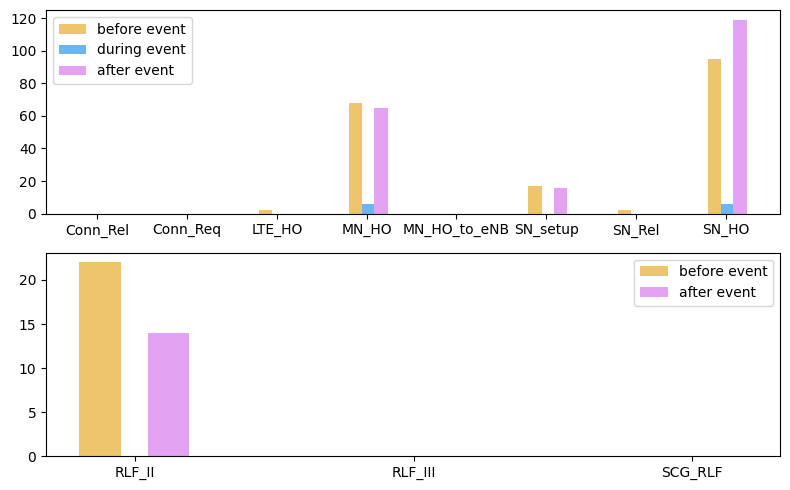

In [576]:
plot_event_sums(time, ul_port, success_sum_before_list_ul, success_sum_during_list_ul, success_sum_after_list_ul, failure_sum_before_list_ul, failure_sum_after_list_ul)

In [577]:
# Call the function and store the results
success_sum_before_list_dl, success_sum_during_list_dl, success_sum_after_list_dl, failure_sum_before_list_dl, failure_sum_after_list_dl, success_sum_before_dl, success_sum_during_dl, success_sum_after_dl, failure_sum_before_dl, failure_sum_after_dl = calculate_event_sums_lists(event_counts_dl)

# Print the results
print("Success Sum Before List:", success_sum_before_list_dl)
print("Success Sum During List:", success_sum_during_list_dl)
print("Success Sum After List:", success_sum_after_list_dl)
print("Failure Sum Before List:", failure_sum_before_list_dl)
print("Failure Sum After List:", failure_sum_after_list_dl)

Success Sum Before List: [0, 0, 2, 22, 0, 46, 2, 198]
Success Sum During List: [0, 0, 0, 0, 0, 0, 0, 1]
Success Sum After List: [0, 0, 0, 175, 0, 4, 0, 108]
Failure Sum Before List: [45, 0, 0]
Failure Sum After List: [2, 0, 0]


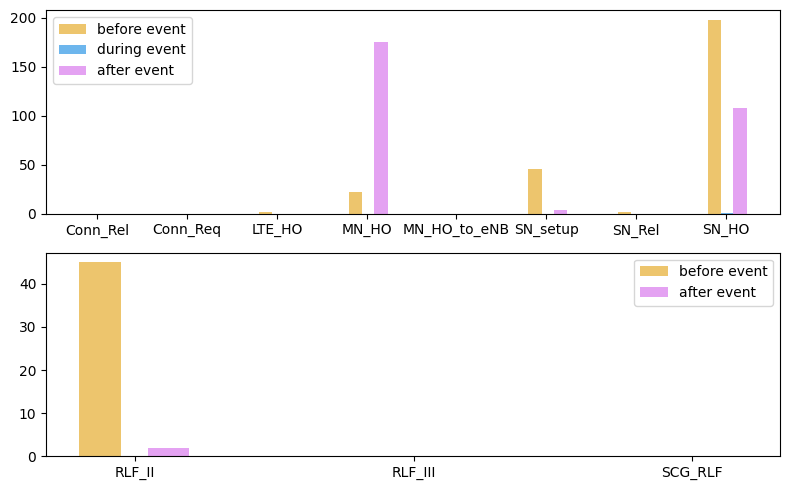

In [578]:
plot_event_sums(time, dl_port, success_sum_before_list_dl, success_sum_during_list_dl, success_sum_after_list_dl, failure_sum_before_list_dl, failure_sum_after_list_dl)

The ratio that packet loss in stable or unstable

In [579]:
# Calculated by "REAL" lost
success_ho_lost_sum_ul = len(ul_real_lost_df[(ul_real_lost_df['ho_type'] >= 1) & (ul_real_lost_df['ho_type'] <= 8)])
failure_ho_lost_sum_ul = len(ul_real_lost_df[(ul_real_lost_df['ho_type'] >= 9) & (ul_real_lost_df['ho_type'] <= 11)])
ho_lost_sum_ul = success_ho_lost_sum_ul + failure_ho_lost_sum_ul
ho_lost_ratio_ul = -1 if len(ul_real_lost_df) == 0 else ho_lost_sum_ul / len(ul_real_lost_df)

success_ho_lost_sum_dl = len(dl_real_lost_df[(dl_real_lost_df['ho_type'] >= 1) & (dl_real_lost_df['ho_type'] <= 8)])
failure_ho_lost_sum_dl = len(dl_real_lost_df[(dl_real_lost_df['ho_type'] >= 9) & (dl_real_lost_df['ho_type'] <= 11)])
ho_lost_sum_dl = success_ho_lost_sum_dl + failure_ho_lost_sum_dl
ho_lost_ratio_dl = -1 if len(dl_real_lost_df) == 0 else ho_lost_sum_dl / len(dl_real_lost_df)

print(ho_lost_ratio_ul, ho_lost_ratio_dl)

0.29310344827586204 0.5436337625178826


In [580]:
def LossProportion(data, time, port, comment):

    labels = [key for key, value in data.items() if value != 0]
    sizes = [value for value in data.values() if value != 0]
    colors = [colors_dict[key] for key in labels]

    fig, ax = plt.subplots()
    ax.pie(sizes, autopct='%1.1f%%', startangle=90, colors=colors)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title('Loss Proportion')
    plt.tight_layout(rect=[0, 0, 0.7, 1])
    plt.legend(labels, title="Event Types", loc="center left", bbox_to_anchor=(1, 0.5))

    plt.savefig(f"{figure_path}/{comment}pkl_proportion_{time}_{port}.png")
    plt.show()


In [581]:
all_pkl_sum_ul = {}
success_pkl_sum_ul = {}
failure_pkl_sum_ul = {}

for event_type, ho_type in event_dict.items():
    # Calculate the sum for each event type
    if ho_type in range(1, 9):
        success_pkl_sum_ul[event_type] = len(ul_lost_df[ul_lost_df['ho_type'] == ho_type])
    if ho_type in range(9, 12):
        failure_pkl_sum_ul[event_type] = len(ul_lost_df[ul_lost_df['ho_type'] == ho_type])

all_pkl_sum_ul = {**success_pkl_sum_ul, **failure_pkl_sum_ul}
all_pkl_sum_ul['stable'] = len(ul_lost_df[ul_lost_df['ho_type'] == 0])

print(success_pkl_sum_ul)
print(failure_pkl_sum_ul)

{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 2, 'MN_HO': 139, 'MN_HO_to_eNB': 0, 'SN_setup': 31, 'SN_Rel': 0, 'SN_HO': 134}
{'RLF_II': 11, 'RLF_III': 0, 'SCG_RLF': 0}


In [582]:
all_pkl_sum_dl = {}
success_pkl_sum_dl = {}
failure_pkl_sum_dl = {}

for event_type, ho_type in event_dict.items():
    # Calculate the sum for each event type
    if ho_type in range(1, 9):
        success_pkl_sum_dl[event_type] = len(dl_lost_df[dl_lost_df['ho_type'] == ho_type])
    if ho_type in range(9, 12):
        failure_pkl_sum_dl[event_type] = len(dl_lost_df[dl_lost_df['ho_type'] == ho_type])

all_pkl_sum_dl = {**success_pkl_sum_dl, **failure_pkl_sum_dl}
all_pkl_sum_dl['stable'] = len(dl_lost_df[dl_lost_df['ho_type'] == 0])

print(success_pkl_sum_dl)
print(failure_pkl_sum_dl)

{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 2, 'MN_HO': 197, 'MN_HO_to_eNB': 0, 'SN_setup': 49, 'SN_Rel': 0, 'SN_HO': 178}
{'RLF_II': 0, 'RLF_III': 0, 'SCG_RLF': 0}


In [583]:
all_real_pkl_sum_ul = {}
success_real_pkl_sum_ul = {}
failure_real_pkl_sum_ul = {}

for event_type, ho_type in event_dict.items():
    # Calculate the sum for each event type
    if ho_type in range(1, 9):
        success_real_pkl_sum_ul[event_type] = len(ul_real_lost_df[ul_real_lost_df['ho_type'] == ho_type])
    if ho_type in range(9, 12):
        failure_real_pkl_sum_ul[event_type] = len(ul_real_lost_df[ul_real_lost_df['ho_type'] == ho_type])

all_real_pkl_sum_ul = {**success_real_pkl_sum_ul, **failure_real_pkl_sum_ul}
all_real_pkl_sum_ul['stable'] = len(ul_real_lost_df[ul_real_lost_df['ho_type'] == 0])

print(len(ul_real_lost_df), success_ho_lost_sum_ul, failure_ho_lost_sum_ul)
print(success_real_pkl_sum_ul)
print(failure_real_pkl_sum_ul)

174 51 0
{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 0, 'MN_HO': 19, 'MN_HO_to_eNB': 0, 'SN_setup': 18, 'SN_Rel': 0, 'SN_HO': 14}
{'RLF_II': 0, 'RLF_III': 0, 'SCG_RLF': 0}


In [584]:
all_real_pkl_sum_dl = {}
success_real_pkl_sum_dl = {}
failure_real_pkl_sum_dl = {}

for event_type, ho_type in event_dict.items():
    # Calculate the sum for each event type
    if ho_type in range(1, 9):
        success_real_pkl_sum_dl[event_type] = len(dl_real_lost_df[dl_real_lost_df['ho_type'] == ho_type])
    if ho_type in range(9, 12):
        failure_real_pkl_sum_dl[event_type] = len(dl_real_lost_df[dl_real_lost_df['ho_type'] == ho_type])

all_real_pkl_sum_dl = {**success_real_pkl_sum_dl, **failure_real_pkl_sum_dl}
all_real_pkl_sum_dl['stable'] = len(dl_real_lost_df[dl_real_lost_df['ho_type'] == 0])

print(success_real_pkl_sum_dl)
print(failure_real_pkl_sum_dl)

{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 0, 'MN_HO': 175, 'MN_HO_to_eNB': 0, 'SN_setup': 45, 'SN_Rel': 0, 'SN_HO': 160}
{'RLF_II': 0, 'RLF_III': 0, 'SCG_RLF': 0}


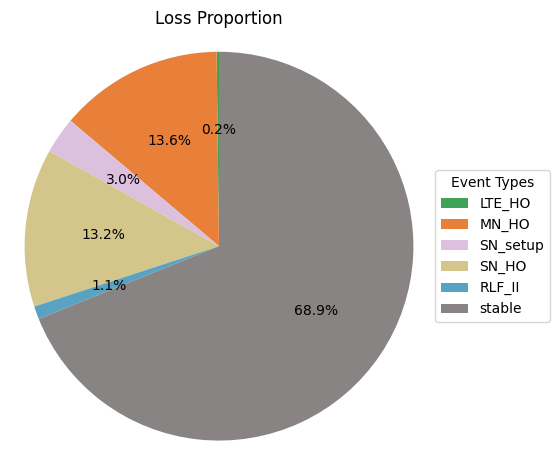

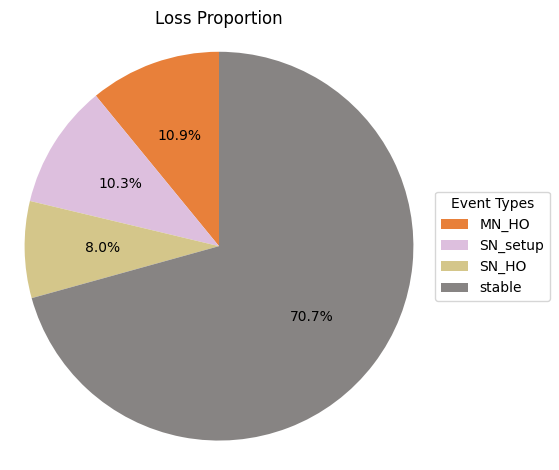

In [585]:
LossProportion(all_pkl_sum_ul, time, ul_port, "")
LossProportion(all_real_pkl_sum_ul, time, ul_port, "adjusted_")

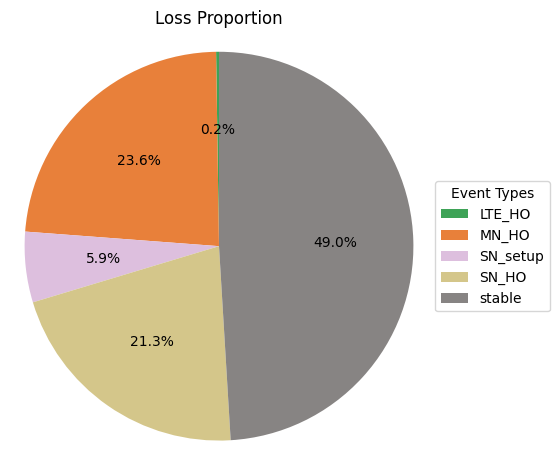

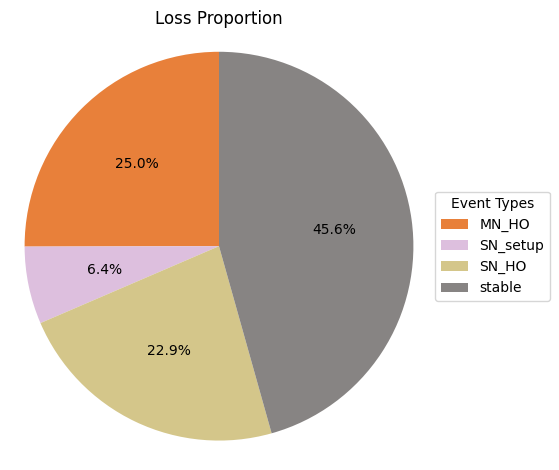

In [586]:
LossProportion(all_pkl_sum_dl, time, dl_port, "")
LossProportion(all_real_pkl_sum_dl, time, dl_port, "adjusted_")

Congestion Window

In [587]:
def CwndWithPkl(df, lost_df, time, port):
    # Create a plot with events marked on the x-axis
    plt.figure(figsize=(50, 10))

    # Set x-axis as timestamp
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Timestamp')

    # Adding vertical lines for lost packets
    for _, row in lost_df.iterrows():
        lost_time = row['timestamp']
        plt.axvline(x=lost_time, color='brown', linestyle='--', label='Lost Packet')

    # Plot the congestion window
    # sm01_ul['timestamp'] = pd.to_datetime(sm01_ul['timestamp'])
    plt.plot(df['timestamp'], df['congestion_window'], marker='o', markersize=0.5, color='green', label='Congestion Window')

    plt.title("Congestion Window & Packet Loss")
    plt.tight_layout()
    plt.savefig(f"{figure_path}/pkl_cwnd_{time}_{port}.png")
    plt.show()

def RttWithLenWithPkl(df, lost_df, time, port):
    # Set the figure size to make the plot wider
    fig, ax1 = plt.subplots(figsize=(50, 10))
    # Plot the 'congestion_window' column on the primary y-axis

    color2 = 'tab:blue'
    ax1.set_ylim(0, 300)
    ax1.set_ylabel('Latest RTT', color=color2)
    ax1.plot(df['timestamp'], df['latest_rtt'], marker='s', markersize=1, color=color2, label='latest_rtt')
    ax1.tick_params(axis='y', labelcolor=color2)

    # Plot the 'length' on the secondary y-axis
    ax2 = ax1.twinx()
    color3 = 'tab:green'
    ax2.plot(df['timestamp'], df['length'], marker='s', markersize=1, color=color3, label='length')
    ax2.tick_params(axis='y', labelcolor=color3)

    # Adding vertical lines for lost packets
    for _, row in lost_df.iterrows():
        lost_time = row['timestamp']
        plt.axvline(x=lost_time, color='brown', linestyle='--', label='Lost Packet')

    # Set title
    plt.title("RTT & Stream Length & Packet Loss")
    plt.tight_layout()
    plt.savefig(f"{figure_path}/rtt_length_{time}_{port}.png")
    plt.show()

def HoWithPkl(ordered_HOs, lost_df, time, port, comment):
    # Convert the list to a DataFrame
    df_events = pd.DataFrame(ordered_HOs, columns=['Event', 'Start Time', 'End Time'])

    # Extract timestamp information from HO and MR objects
    df_events['Start Time'] = df_events['Start Time'].apply(lambda x: x.start if hasattr(x, 'start') else (x.time if hasattr(x, 'time') else None))
    df_events['End Time'] = df_events['End Time'].apply(lambda x: x.end if hasattr(x, 'end') else (x.time if hasattr(x, 'time') else None))

    df_events['Start Time'] = pd.to_datetime(df_events['Start Time'])
    df_events['End Time'] = pd.to_datetime(df_events['End Time'].fillna(df_events['Start Time']))

    # Create a plot with events marked on the x-axis
    plt.figure(figsize=(50, 10))
    plt.plot(df_events['Start Time'], [0] * len(df_events), 'o', label='Start Time', markersize=2)
    plt.plot(df_events['End Time'], [1] * len(df_events), 'o', label='End Time', markersize=2)

    # Set x-axis as timestamp
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Timestamp')

    # Add event labels
    # for i, event in df_events.iterrows():
    #     plt.text(event['Start Time'], 0, f'{event["Event"]} (Start)', fontsize=8, ha='right')
    #     plt.text(event['End Time'], 1, f'{event["Event"]} (End)', fontsize=8, ha='right')

    # Draw rectangles for each section
    for _, event in df_events.iterrows():
        start_time = event['Start Time']
        end_time = event['End Time']

        # Add a rectangle for 1 second before the event start
        rect_before = Rectangle((start_time - pd.Timedelta(seconds=1), -0.5), pd.Timedelta(seconds=1), 5, alpha=0.5, color='lightblue')
        plt.gca().add_patch(rect_before)

        # Add a rectangle for the event duration
        rect = Rectangle((start_time, -0.5), end_time - start_time, 5, alpha=1, color='blue')
        plt.gca().add_patch(rect)

        # Add a rectangle for 1 second after the event end
        rect_after = Rectangle((end_time, -0.5), pd.Timedelta(seconds=1), 5, alpha=0.5, color='lightblue')
        plt.gca().add_patch(rect_after)

    # Adding vertical lines for lost packets
    for _, row in lost_df.iterrows():
        if row['trigger'] == "time_threshold":
            lost_time = row['timestamp']
            plt.axvline(x=lost_time, color='brown', linestyle='--', label='Lost Packet')
        else:
            lost_time = row['timestamp']
            plt.axvline(x=lost_time, color='coral', linestyle='--', label='Lost Packet')
        

    plt.title(f"Handover & Packet Loss")
    plt.tight_layout()
    plt.savefig(f"{figure_path}/{comment}ho_timeline_{time}_{port}.png")
    plt.show()


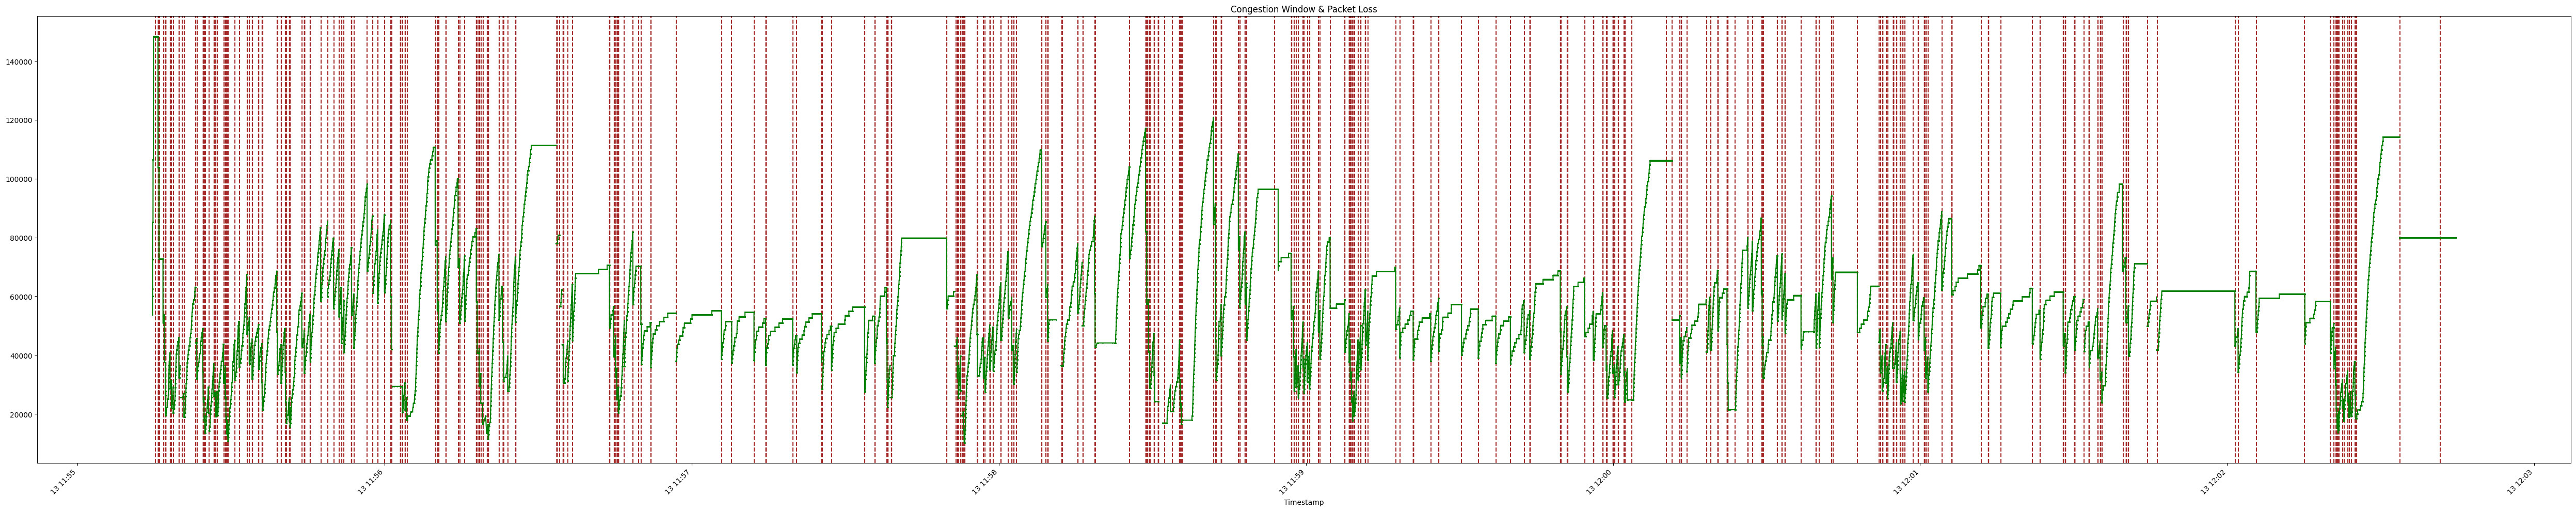

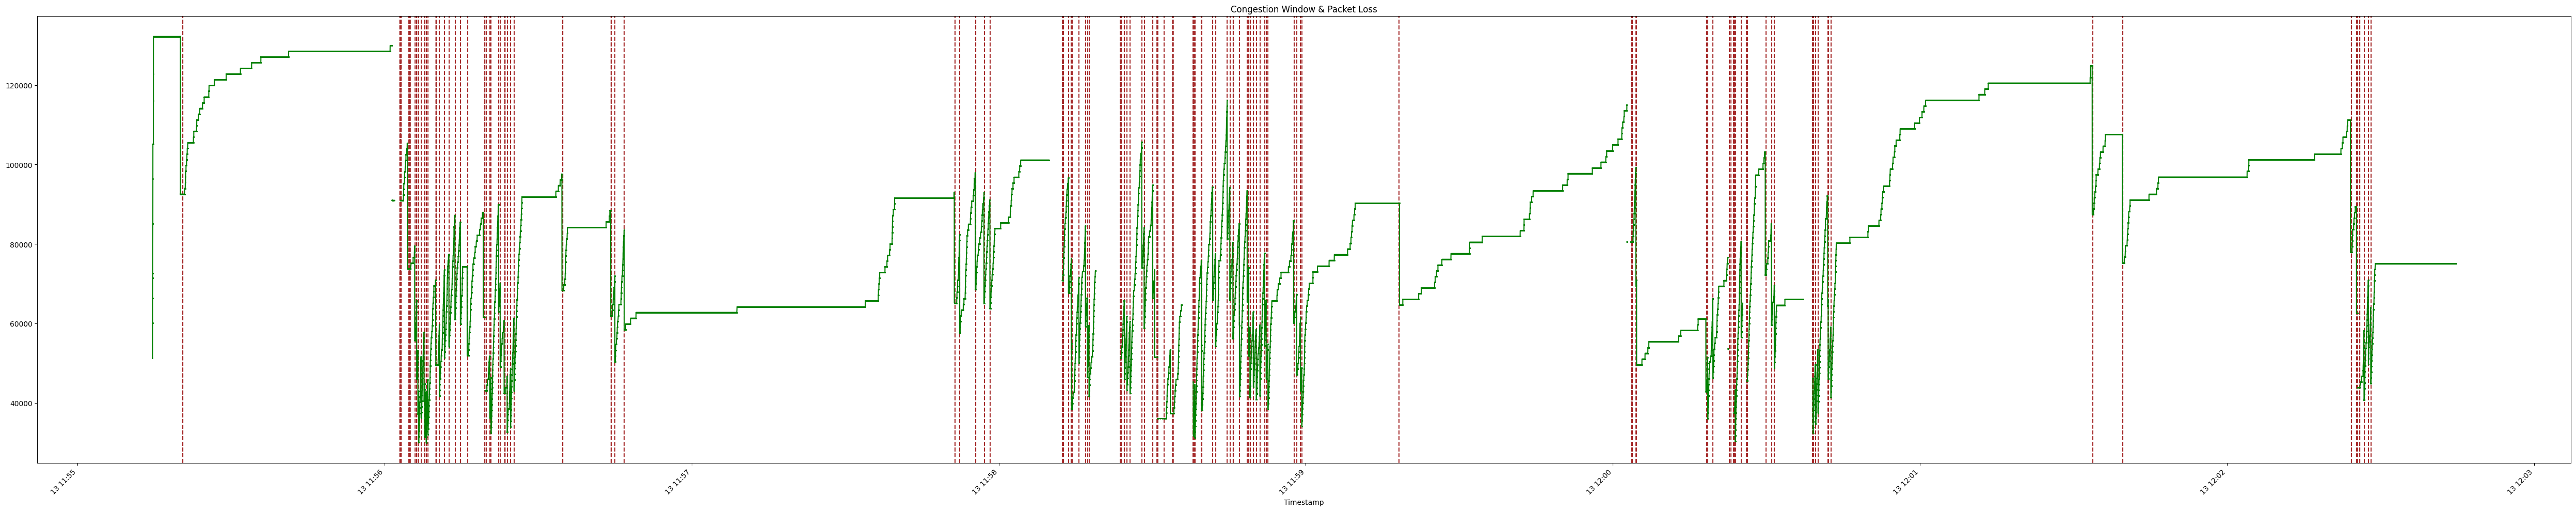

In [588]:
CwndWithPkl(ul_sent_df, ul_lost_df, time, ul_port)
CwndWithPkl(dl_sent_df, dl_lost_df, time, dl_port)

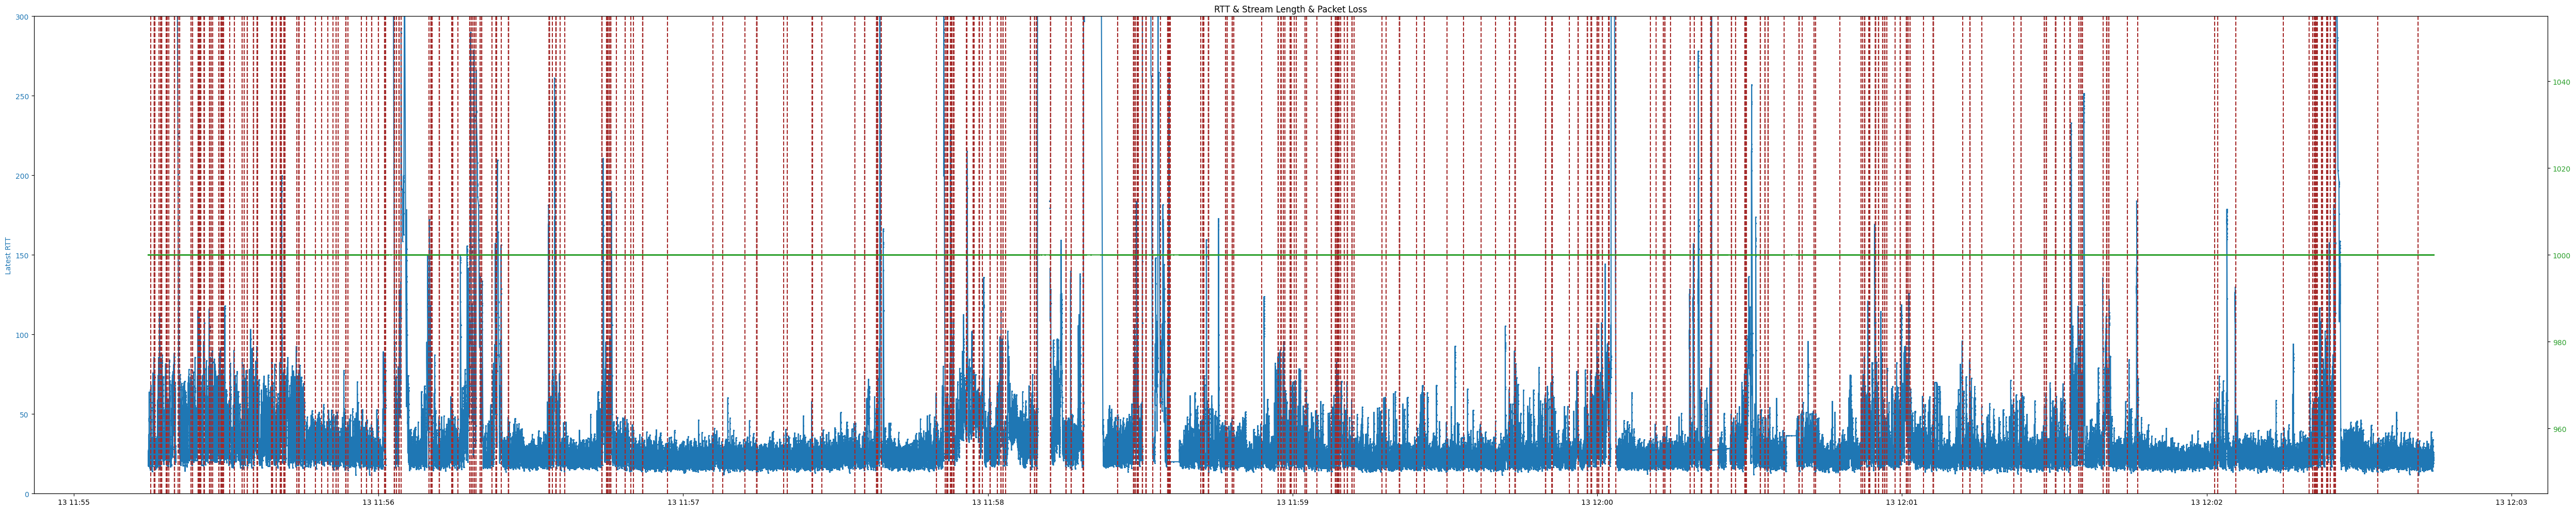

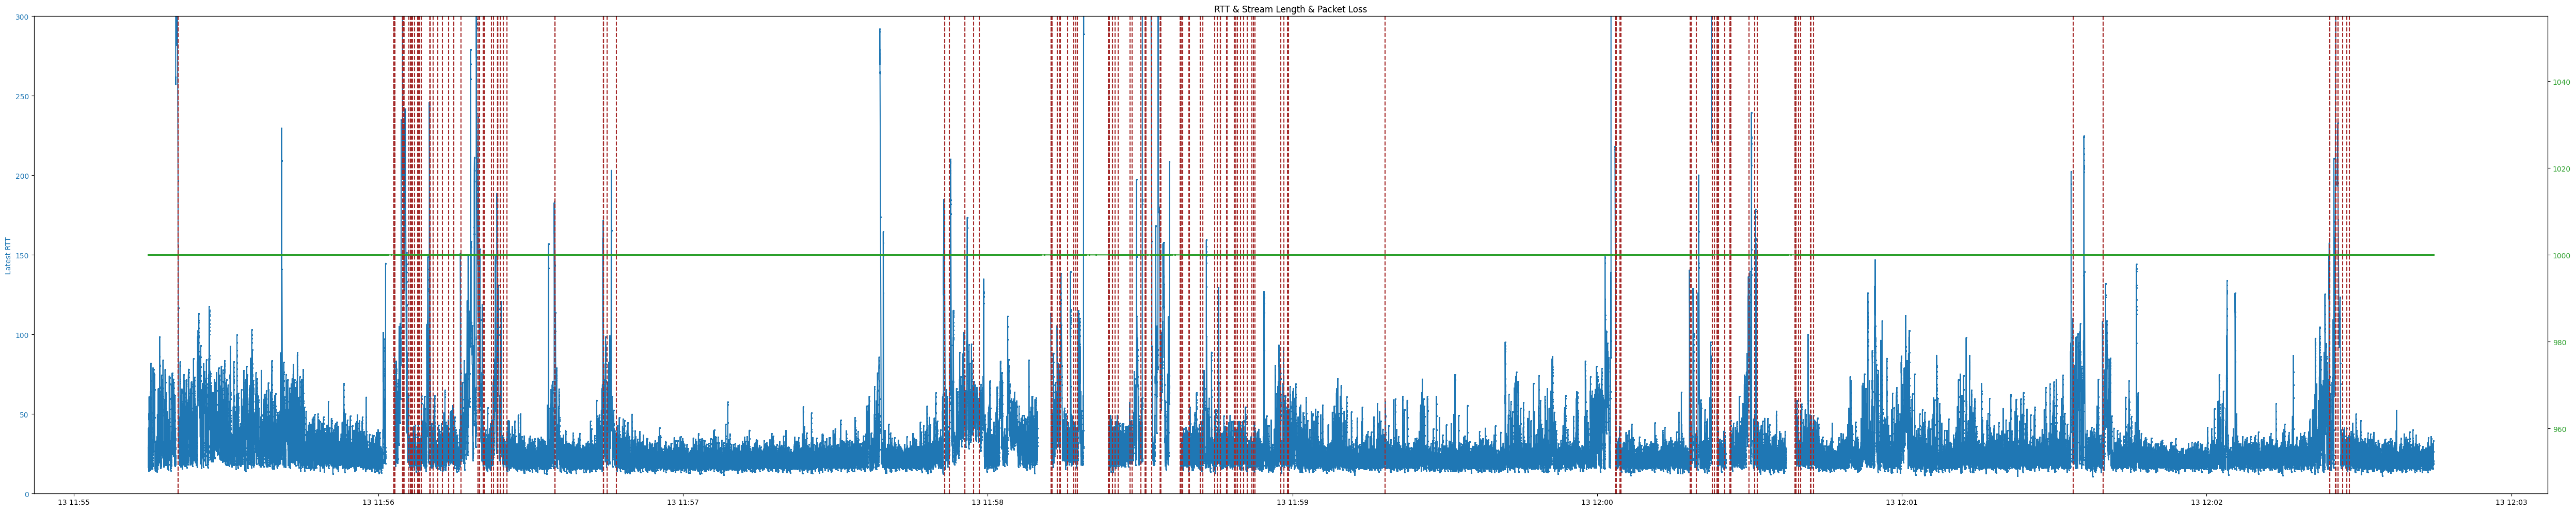

In [589]:
RttWithLenWithPkl(ul_sent_df, ul_lost_df, time, ul_port)
RttWithLenWithPkl(dl_sent_df, dl_lost_df, time, dl_port)

In [590]:
ul_weird_length = ul_sent_df[ul_sent_df['length'] != 1000]
dl_weird_length = dl_sent_df[dl_sent_df['length'] != 1000]
print("pkl:", len(ul_lost_df), len(dl_lost_df))
print("weird length:", len(ul_weird_length), len(dl_weird_length))

pkl: 1019 836
weird length: 0 0


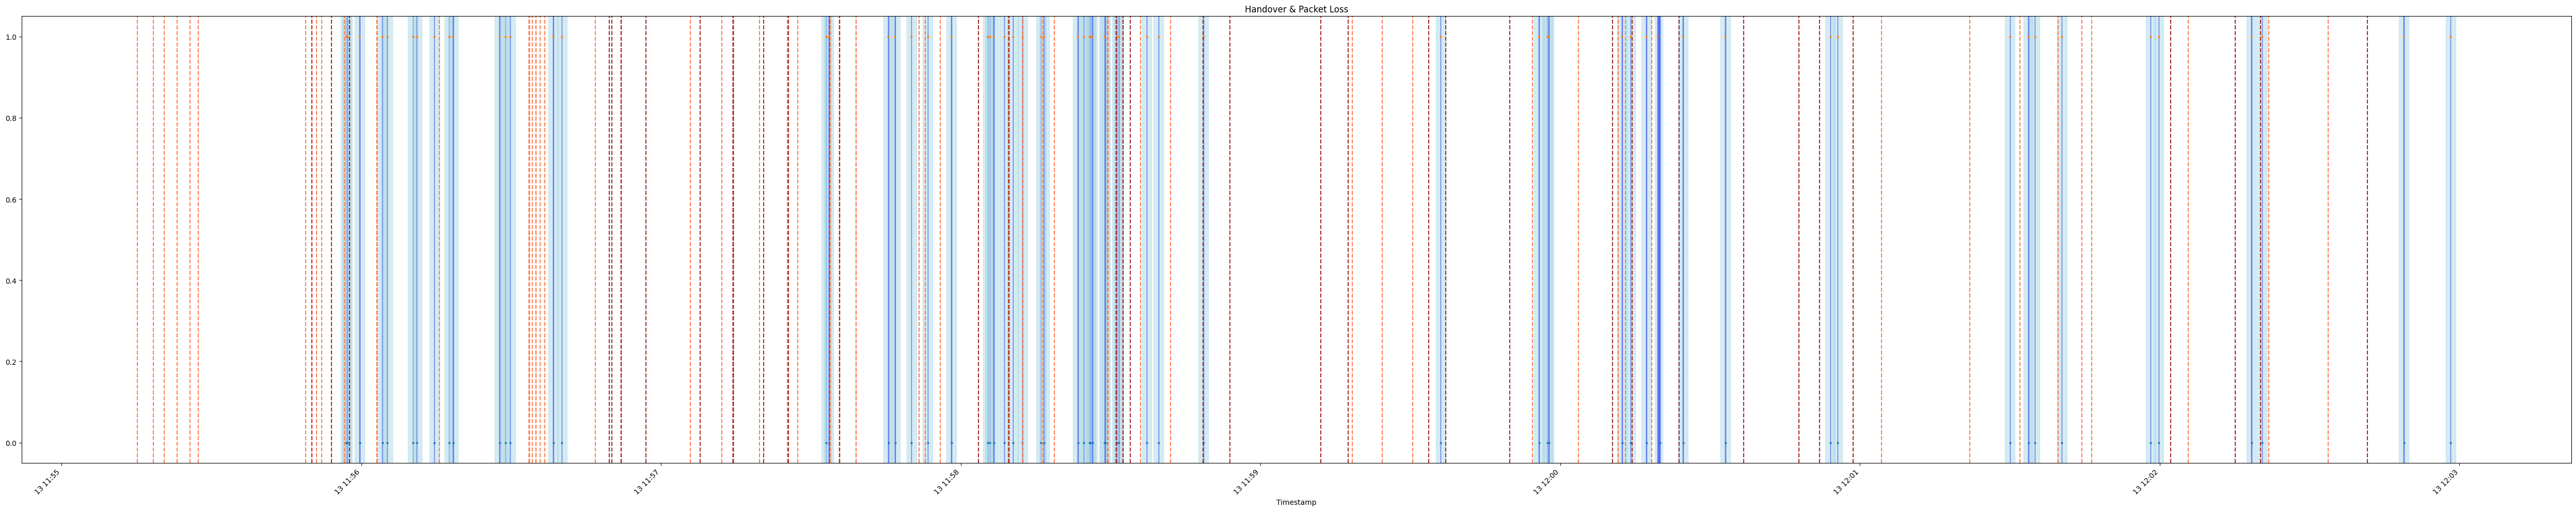

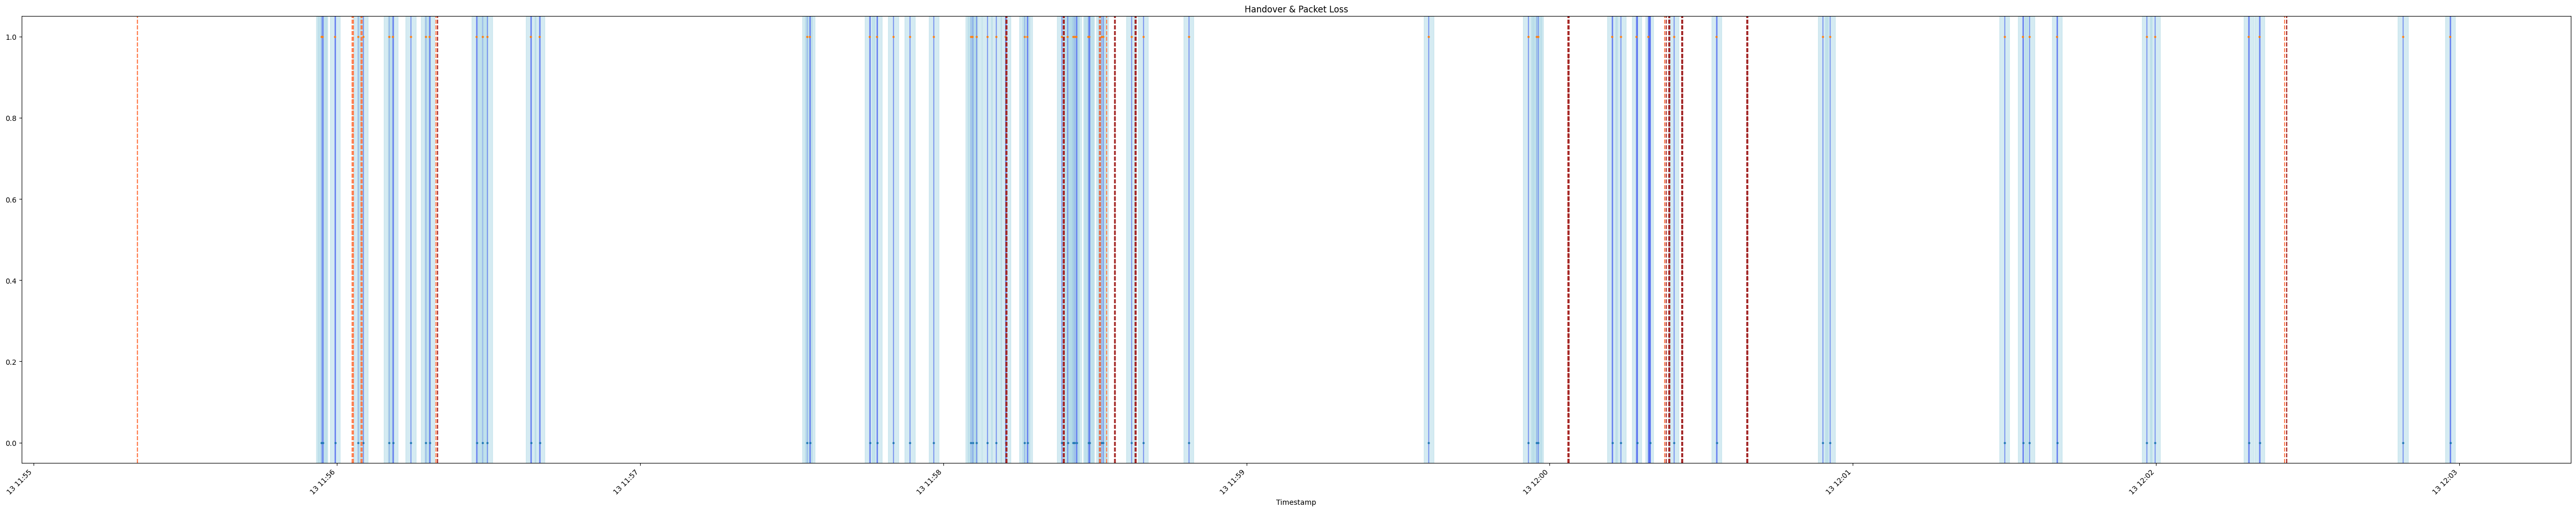

In [591]:
HoWithPkl(filtered_time_ordered_HO, ul_real_lost_df, time, ul_port, "")
HoWithPkl(filtered_time_ordered_HO, dl_real_lost_df, time, dl_port, "")

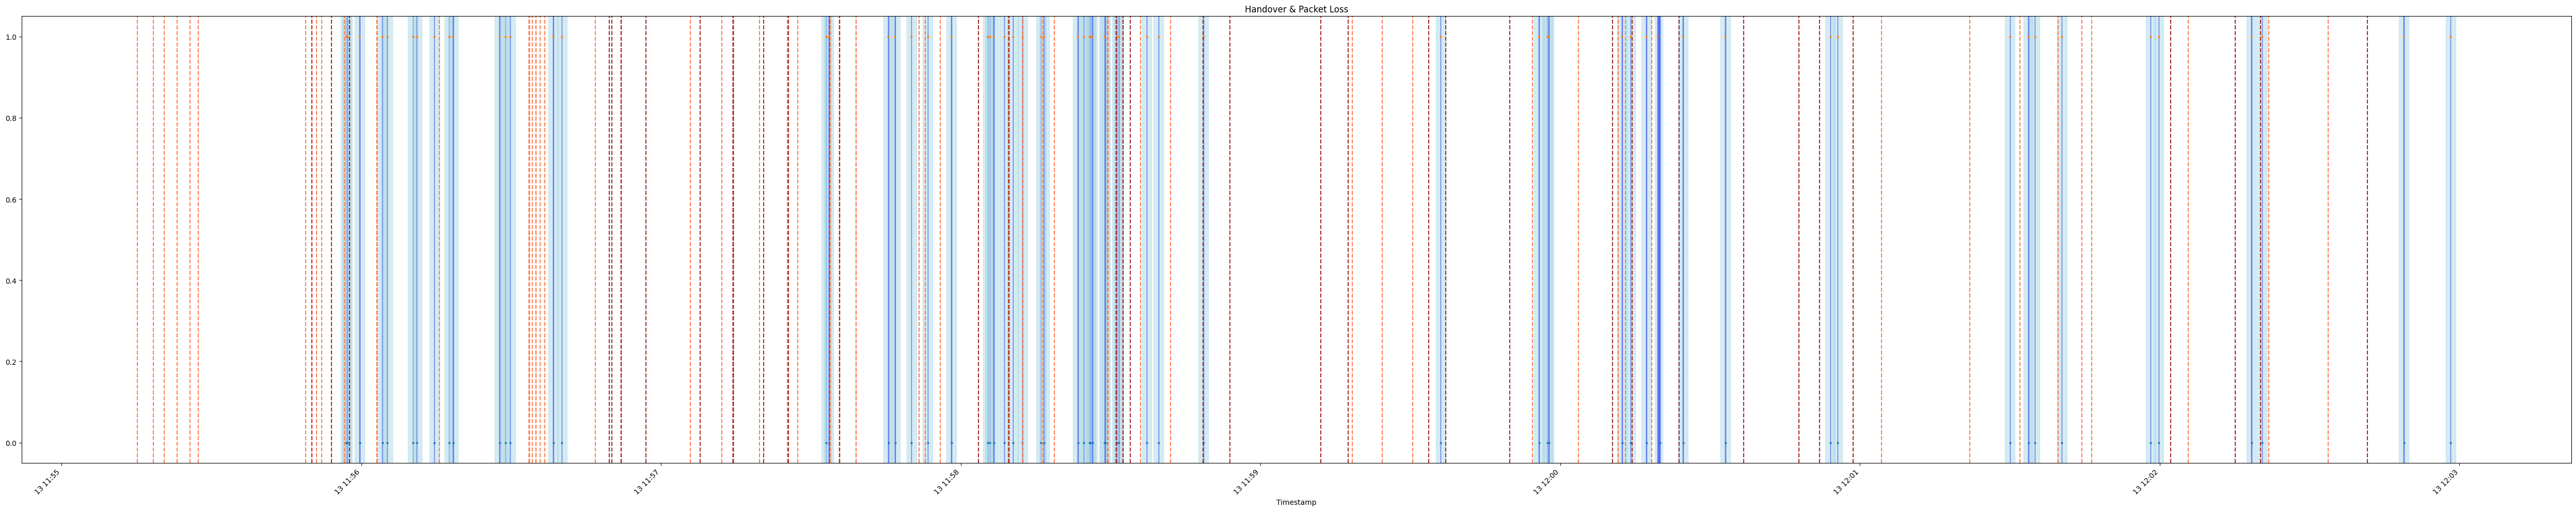

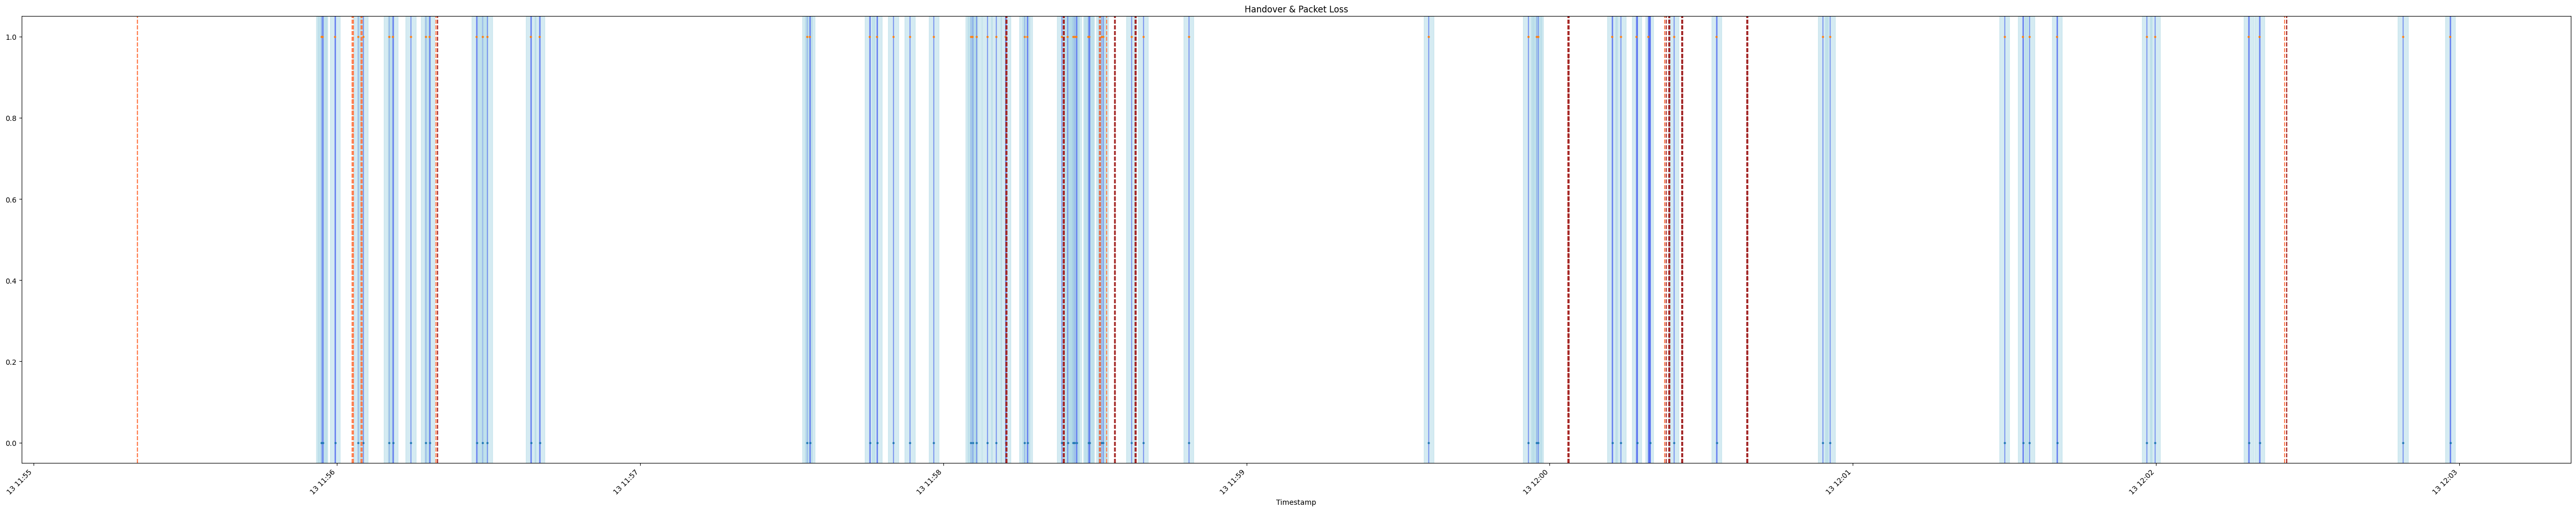

In [592]:
# the timeline for "REAL" packet loss
HoWithPkl(filtered_time_ordered_HO, ul_real_lost_df, time, ul_port, "adjusted_")
HoWithPkl(filtered_time_ordered_HO, dl_real_lost_df, time, dl_port, "adjusted_")

In [593]:
def PlotHoFreq(all_ho_count):
    # Sort the data by values in descending order
    sorted_data = dict(sorted(all_ho_count.items(), key=lambda item: item[1], reverse=True))
    print(sorted_data)
    # Extract keys and values
    keys = list(sorted_data.keys())
    values = list(sorted_data.values())

    # Plot the data with colors
    plt.figure(figsize=(12, 6))
    plt.bar(keys, values, color=[colors_dict[key] for key in keys])
    plt.xlabel('Event Type')
    plt.ylabel('Frequency')
    plt.title('Frequency of Event Occurrence')
    plt.tight_layout()
    plt.savefig(f"{figure_path}/ho_frequency.png")
    plt.show()

{'Conn_Rel': 3, 'Conn_Req': 3, 'LTE_HO': 1, 'MN_HO': 22, 'MN_HO_to_eNB': 0, 'SN_setup': 9, 'SN_Rel': 1, 'SN_HO': 29, 'RLF_II': 5, 'RLF_III': 0, 'SCG_RLF': 0}
{'SN_HO': 29, 'MN_HO': 22, 'SN_setup': 9, 'RLF_II': 5, 'Conn_Rel': 3, 'Conn_Req': 3, 'LTE_HO': 1, 'SN_Rel': 1, 'MN_HO_to_eNB': 0, 'RLF_III': 0, 'SCG_RLF': 0}


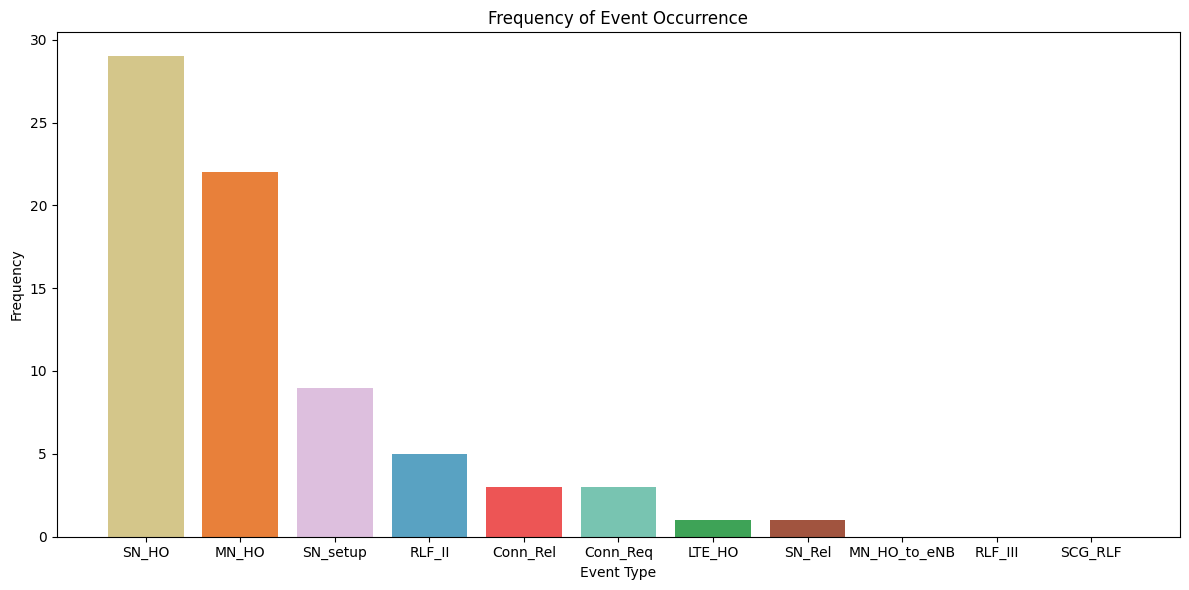

In [594]:
## Calulate the occurrence of every event
ho_count = {key: len(value) for key, value in HOs.items() if key != "Add_SCell"}
# Print the lengths dictionary
print(ho_count)

PlotHoFreq(ho_count)

## Retransmission

In [595]:
# dl_file = "/Volumes/MOLLY256/MOXA/2024-02-03/QUIC-300sec/sm00/#01/data/processed_sent_1039_4201.csv"
# dl_lost_file = "/Volumes/MOLLY256/MOXA/2024-02-03/QUIC-300sec/sm00/#01/middle/lost_pk_1039_4201.csv"
# dl_df = pd.read_csv(dl_file, sep='@')
# dl_lost_df = pd.read_csv(dl_lost_file)
# ul_file = "/Volumes/MOLLY256/MOXA/2024-02-03/QUIC-300sec/sm00/#01/data/processed_sent_1039_4200.csv"
# ul_lost_file = "/Volumes/MOLLY256/MOXA/2024-02-03/QUIC-300sec/sm00/#01/middle/lost_pk_1039_4200.csv"
# ul_df = pd.read_csv(ul_file, sep='@')
# ul_lost_df = pd.read_csv(ul_lost_file)

In [596]:
# dl_length = dl_df['length'].sum()
# dl_lost_info = dl_df[dl_df['packet_number'].isin(dl_lost_df['packet_number'])]
# dl_lost_length = dl_lost_info['length'].sum()
# print("DL Total length:", dl_length)

# ul_length = ul_df['length'].sum()
# ul_lost_info = ul_df[dl_df['packet_number'].isin(ul_lost_df['packet_number'])]
# ul_lost_length = ul_lost_info['length'].sum()
# print("UL Total length:", ul_length)

In [597]:
# dl_df_len = len(dl_df)
# dl_retrans_length = dl_length - dl_df.iloc[dl_df_len-1]['offset']
# print(dl_lost_length, dl_retrans_length)

# ul_df_len = len(ul_df)
# ul_retrans_length = ul_length - ul_df.iloc[ul_df_len-1]['offset']
# print(ul_lost_length, ul_retrans_length)